# Plotting timeseries of Arctic Temperature gradient terms - bootstrapped means

* **Description**: Plots historical and future timeseries by month and region
* **Input data**: Processed rufmod and cesm2-le regional total netcdf files
* **Output data**: Timeseries plots in png format
* **Creator**: Alice DuVivier
* **Date**: August 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t, ttest_ind
import nc_time_axis

## Read in the processed data

This reads in pre-processed regional average atmospheric circulation for the Arctic Ocean


In [2]:
# list the variables to load
var_in_1 = 'TS'
var_in_2 = 'T'

In [3]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_6/fig_9_temp_grad/'

# set file names
fin_le_1 = 'CESM2-LE_seas_'+var_in_1
fin_smooth_1 = 'rufmod_seas_'+var_in_1

fin_le_2 = 'CESM2-LE_seas_'+var_in_2
fin_smooth_2 = 'rufmod_seas_'+var_in_2

In [4]:
ds_le_1 = xr.open_dataset(data_dir+fin_le_1+'.nc',decode_times=True)
ds_smooth_1 = xr.open_dataset(data_dir+fin_smooth_1+'.nc',decode_times=True)

ds_le_2 = xr.open_dataset(data_dir+fin_le_2+'.nc',decode_times=True)
ds_smooth_2 = xr.open_dataset(data_dir+fin_smooth_2+'.nc',decode_times=True)

In [5]:
data_le_1 = ds_le_1['__xarray_dataarray_variable__']
data_smooth_1 = ds_smooth_1['__xarray_dataarray_variable__']

data_le_2 = ds_le_2['__xarray_dataarray_variable__']
data_smooth_2 = ds_smooth_2['__xarray_dataarray_variable__']

print(data_le_1.units)
print(data_le_1.longname)
print(data_le_2.longname)

K
surface temperature
temperature aloft at given plevels


In [6]:
# convert to Celsius from Kelvin
data_le_1 = data_le_1 - 273.15
data_smooth_1 = data_smooth_1 - 273.15

data_le_2 = data_le_2 - 273.15
data_smooth_2 = data_smooth_2 - 273.15

## Mask Arctic Ocean only

In [7]:
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/mask_plots/ATM_MASK_ArcOc.nc')


In [8]:
my_mask = ds_masks['atm_ArcOc_mask']

In [9]:
my_mask

<xarray.DataArray 'atm_ArcOc_mask' (lat: 192, lon: 288)>
dask.array<open_dataset-da90c46d10fd21b010e08c82e53c0a7aatm_ArcOc_mask, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

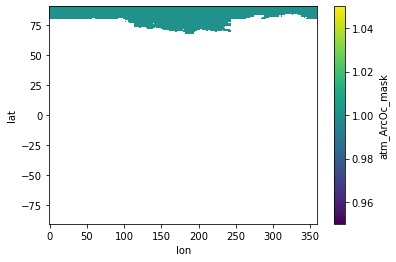

In [10]:
my_mask.plot()

In [11]:
# get just NH slice
my_mask = my_mask.isel(lat=slice(164,192))

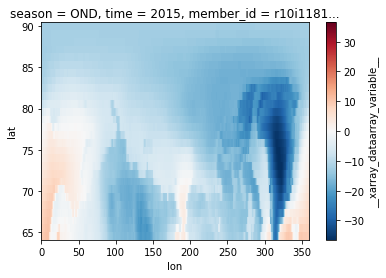

In [12]:
# check data
data_le_1.isel(season=0,member_id=0,time=0).plot()

In [13]:
# set lat/lon the same as mask so it doesn't get messed up
data_le_1['lat'] = my_mask.lat
data_le_1['lon'] = my_mask.lon

data_smooth_1['lat'] = my_mask.lat
data_smooth_1['lon'] = my_mask.lon

data_le_2['lat'] = my_mask.lat
data_le_2['lon'] = my_mask.lon

data_smooth_2['lat'] = my_mask.lat
data_smooth_2['lon'] = my_mask.lon

In [14]:
# mask just Arctic Ocean
data_le_1_masked = data_le_1.where(my_mask==1)
data_smooth_1_masked = data_smooth_1.where(my_mask==1)

data_le_2_masked = data_le_2.where(my_mask==1)
data_smooth_2_masked = data_smooth_2.where(my_mask==1)

In [15]:
print(data_le_1_masked.shape)
print(data_smooth_1_masked.shape)

(4, 86, 50, 28, 288)
(4, 86, 5, 28, 288)


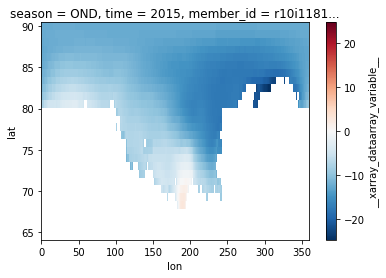

In [16]:
#just test that it worked properly
data_le_1_masked.isel(season=0,member_id=0,time=0).plot()

In [17]:
data_le_1_masked

<xarray.DataArray '__xarray_dataarray_variable__' (season: 4, time: 86, member_id: 50, lat: 28, lon: 288)>
dask.array<where, shape=(4, 86, 50, 28, 288), dtype=float64, chunksize=(4, 86, 50, 28, 288), chunktype=numpy.ndarray>
Coordinates:
  * season     (season) object 'OND' 'JFM' 'AMJ' 'JAS'
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
  * lat        (lat) float64 64.55 65.5 66.44 67.38 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

## Grab just 850hPa

In [18]:
plev_all = data_le_2_masked.plev
plev_full = ['925', '850', '700', '500']

In [19]:
plev_all

<xarray.DataArray 'plev' (plev: 4)>
array([92500, 85000, 70000, 50000])
Coordinates:
  * plev     (plev) int64 92500 85000 70000 50000

In [20]:
plev = 85000

In [21]:
data_le_850 = data_le_2_masked.sel(plev = plev)
data_rufmod_850 = data_smooth_2_masked.sel(plev = plev)


## Make Arctic Ocean averages

In [22]:
# average over all unmasked points
avg_le_1 = data_le_1_masked.mean(dim=['lat','lon'])
avg_smooth_1 = data_smooth_1_masked.mean(dim=['lat','lon'])

avg_le_2 = data_le_850.mean(dim=['lat','lon'])
avg_smooth_2 = data_rufmod_850.mean(dim=['lat','lon'])

## Calculate ensemble means

In [23]:
seas_le_1 = avg_le_1
seas_smooth_1 = avg_smooth_1

seas_le_2 = avg_le_2
seas_smooth_2 = avg_smooth_2

In [24]:
# set x arrays against which to plot
xarr_le = seas_le_1.coords['time']
xarr_smooth = seas_le_1.coords['time']

In [25]:
xarr_le

<xarray.DataArray 'time' (time: 86)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050,
       2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086,
       2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100])
Coordinates:
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [26]:
season_names = ['OND','JFM','AMJ','JAS']
season_full = ['b) Autumn', 'd) Winter', 'f) Spring', 'h) Summer']

In [27]:
#seas_le = seas_le.transpose()
#seas_smooth = seas_smooth.transpose()
print(seas_le_1.shape)
print(seas_smooth_1.shape)

(4, 86, 50)
(4, 86, 5)


In [28]:
# calculate ensemble mean for SMOOTH and CESM2-LE over all members
seas_ens_mean_le_1 = seas_le_1.mean(dim='member_id')
seas_ens_mean_smooth_1 = seas_smooth_1.mean(dim='member_id')

seas_ens_mean_le_2 = seas_le_2.mean(dim='member_id')
seas_ens_mean_smooth_2 = seas_smooth_2.mean(dim='member_id')

In [29]:
# calculate statistical significance
sigval = 0.05

# calculate statistical significance
tval,pval = ttest_ind(seas_le_1,seas_smooth_1,axis=2,equal_var=False)
seas_ens_mean_le_sig_1 = seas_ens_mean_le_1.where(pval <= sigval)
seas_ens_mean_smooth_sig_1 = seas_ens_mean_smooth_1.where(pval <= sigval)

tval,pval = ttest_ind(seas_le_2,seas_smooth_2,axis=2,equal_var=False)
seas_ens_mean_le_sig_2 = seas_ens_mean_le_2.where(pval <= sigval)
seas_ens_mean_smooth_sig_2 = seas_ens_mean_smooth_2.where(pval <= sigval)

In [30]:
print(seas_ens_mean_le_1.shape)
print(seas_ens_mean_smooth_1.shape)

(4, 86)
(4, 86)


## Calculate bootstrapped means

Bootstrap the CESM2-LE (N=50) to find ensemble means using the same number of members as SMOOTH (N=5)

# bootstrap the CESM2-LE 1000 times
n_bs=2
#n_bs=1000
seas_bs_array_le = np.zeros([len(season_names),len(xarr_le),n_bs])

for ii in range(n_bs):
    # choose random ensemble member numbers
    mem1=np.random.choice(range(0,49))
    mem2=np.random.choice(range(0,49))
    mem3=np.random.choice(range(0,49))
    mem4=np.random.choice(range(0,49))
    mem5=np.random.choice(range(0,49)) 
    # now average those random ensembles
    temp = np.stack((seas_le.isel(member_id=mem1),seas_le.isel(member_id=mem2),seas_le.isel(member_id=mem3),
                     seas_le.isel(member_id=mem4),seas_le.isel(member_id=mem5)),axis=-1)
    temp2 = np.mean(temp,axis=2)
    seas_bs_array_le[:,:,ii]=temp2

In [31]:
#seas_bs_array_le.shape

In [32]:
# convert the numpy array to a xarray for easier plotting
#seas_bs_le = xr.DataArray(seas_bs_array_le,dims=('season','time','bootstrap_num'))

## Plot the figures

## Add linear regressions

In [33]:
# note that the CESM2-LE time bounds for regressions are:
# 2020-2100: 5-85
print(xarr_le[5])
print(xarr_le[85])

<xarray.DataArray 'time' ()>
array(2020)
Coordinates:
    time     int64 2020
<xarray.DataArray 'time' ()>
array(2100)
Coordinates:
    time     int64 2100


In [34]:
# note that the rufmod time bounds for regressions are:
# 2020-2100: 5-85
print(xarr_smooth[5])
print(xarr_smooth[85])
#seas_ens_mean_smooth

<xarray.DataArray 'time' ()>
array(2020)
Coordinates:
    time     int64 2020
<xarray.DataArray 'time' ()>
array(2100)
Coordinates:
    time     int64 2100


In [35]:
# test this simply for first season
seas = 0

x = xarr_le[5:85]
y = seas_ens_mean_le_1[seas, 5:85]
regobj = linregress(x,y)
#regobj = scipy.stats.linregress(x,y)
print(regobj)
print('rate = '+str(10*regobj.slope)+' C/decade')
print('r2='+str((regobj.rvalue*regobj.rvalue)))

LinregressResult(slope=0.17471917684911764, intercept=-367.1540023700075, rvalue=0.997935034876092, pvalue=9.112663484067496e-95, stderr=0.0012733214219631678)
rate = 1.7471917684911764 C/decade
r2=0.995874333833147


In [36]:
#set some labeling info for plots
out_tag = 'T_TS'

label = 'Temperature'
units = '($\circ$ C)'
ymin_all = [-20,-30,-12,-5]
ymax_all = [0,-10,-2,3]
ypos1_all = [-18,-28,-9,-1.5]
ypos2_all = [-19,-29,-9.5,-1.75]
legpos = 'upper left'
  

In [37]:
seas_ens_mean_le_2

<xarray.DataArray '__xarray_dataarray_variable__' (season: 4, time: 86)>
dask.array<mean_agg-aggregate, shape=(4, 86), dtype=float64, chunksize=(4, 86), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'OND' 'JFM' 'AMJ' 'JAS'
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
    plev     int64 85000

CESM2-LE rate 1.74719 ($\circ$ C)/decade; $r^{2}$=1.0
SMOOTH rate 1.69245 ($\circ$ C)/decade; $r^{2}$=0.97
CESM2-LE rate 1.74719 ($\circ$ C)/decade; $r^{2}$=1.0
SMOOTH rate 0.64079 ($\circ$ C)/decade; $r^{2}$=0.95
CESM2-LE rate 1.43201 ($\circ$ C)/decade; $r^{2}$=0.97
SMOOTH rate 1.4142 ($\circ$ C)/decade; $r^{2}$=0.91
CESM2-LE rate 1.43201 ($\circ$ C)/decade; $r^{2}$=0.97
SMOOTH rate 0.55537 ($\circ$ C)/decade; $r^{2}$=0.82
CESM2-LE rate 0.35617 ($\circ$ C)/decade; $r^{2}$=0.98
SMOOTH rate 0.34289 ($\circ$ C)/decade; $r^{2}$=0.87
CESM2-LE rate 0.35617 ($\circ$ C)/decade; $r^{2}$=0.98
SMOOTH rate 0.61525 ($\circ$ C)/decade; $r^{2}$=0.91
CESM2-LE rate 0.27249 ($\circ$ C)/decade; $r^{2}$=0.98
SMOOTH rate 0.26233 ($\circ$ C)/decade; $r^{2}$=0.94
CESM2-LE rate 0.27249 ($\circ$ C)/decade; $r^{2}$=0.98
SMOOTH rate 0.68177 ($\circ$ C)/decade; $r^{2}$=0.94


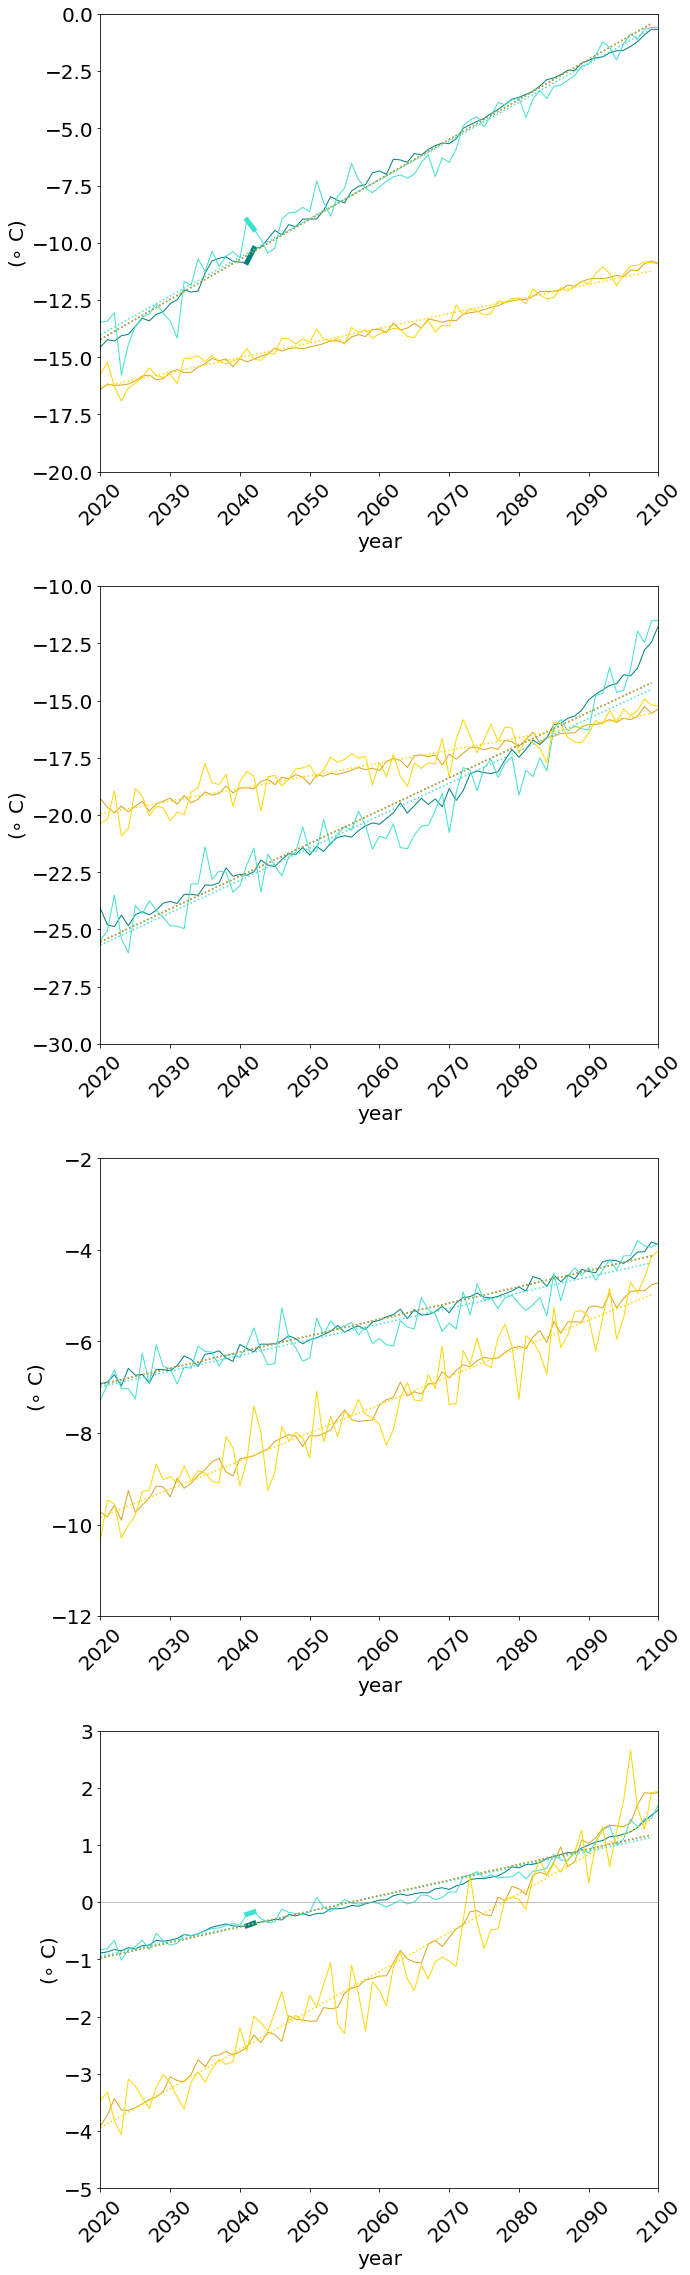

In [38]:
# like above, but add linear regression over the whole period
ind_le_st = 5
ind_le_ed = 85
ind_smooth_st = ind_le_st
ind_smooth_ed = ind_le_ed

# create figure
fig = plt.figure(figsize=(10,40))
# now loop through months to create subpanels
fout = 'fig_11_average_'+out_tag

#for ss in season_names[0:1]:
for ss in season_names:
    #print(ss)
    if ss == 'OND':
        count = 0
    else: 
        count = count+1
    # get limits 
    ymin = ymin_all[count]
    ymax = ymax_all[count]
    ypos1 = ypos1_all[count]
    ypos2 = ypos2_all[count]

    # CESM2-LE: subset the data
    mean_le_1 = seas_ens_mean_le_1.isel(season=count)
    mean_le_sig_1 = seas_ens_mean_le_sig_1.isel(season=count)
    mean_le_2 = seas_ens_mean_le_2.isel(season=count)
    mean_le_sig_2 = seas_ens_mean_le_sig_2.isel(season=count)
    # rufmod: subset the data
    mean_smooth_1 = seas_ens_mean_smooth_1.isel(season=count)
    mean_smooth_sig_1 = seas_ens_mean_smooth_sig_1.isel(season=count)
    mean_smooth_2 = seas_ens_mean_smooth_2.isel(season=count)
    mean_smooth_sig_2 = seas_ens_mean_smooth_sig_2.isel(season=count)
    
    # calculate LE linear regression for whole time period
    x_le = xarr_le[ind_le_st:ind_le_ed]
    y_le_1 = mean_le_1[ind_le_st:ind_le_ed]
    reg_le_1 = linregress(x_le,y_le_1)
    rate_le_1 = 10*reg_le_1.slope
    r2_le_1 = reg_le_1.rvalue*reg_le_1.rvalue
    y_reg_le_1 = (reg_le_1.slope*x_le)+reg_le_1.intercept
    tx_le = 'CESM2-LE rate '+str(round(rate_le_1,5))+' '+units+'/decade; $r^{2}$='+str(round(r2_le_1,2))
    print(tx_le)
    
    # calculate rufmod linear regression for whole time period
    x_smooth = xarr_smooth[ind_smooth_st:ind_smooth_ed]
    y_smooth_1 = mean_smooth_1[ind_smooth_st:ind_smooth_ed]
    reg_smooth_1 = linregress(x_smooth,y_smooth_1)
    rate_smooth_1 = 10*reg_smooth_1.slope
    r2_smooth_1 = reg_smooth_1.rvalue*reg_smooth_1.rvalue
    y_reg_smooth_1 = (reg_smooth_1.slope*x_smooth)+reg_smooth_1.intercept
    tx_smooth = 'SMOOTH rate '+str(round(rate_smooth_1,5))+' '+units+'/decade; $r^{2}$='+str(round(r2_smooth_1,2))
    print(tx_smooth)
    
    # calculate LE linear regression for whole time period
    x_le = xarr_le[ind_le_st:ind_le_ed]
    y_le_2 = mean_le_1[ind_le_st:ind_le_ed]
    reg_le_2 = linregress(x_le,y_le_2)
    rate_le_2 = 10*reg_le_2.slope
    r2_le_2 = reg_le_2.rvalue*reg_le_2.rvalue
    y_reg_le_2 = (reg_le_2.slope*x_le)+reg_le_2.intercept
    tx_le = 'CESM2-LE rate '+str(round(rate_le_2,5))+' '+units+'/decade; $r^{2}$='+str(round(r2_le_2,2))
    print(tx_le)
    
    # calculate rufmod linear regression for whole time period
    x_smooth = xarr_smooth[ind_smooth_st:ind_smooth_ed]
    y_smooth_2 = mean_smooth_2[ind_smooth_st:ind_smooth_ed]
    reg_smooth_2 = linregress(x_smooth,y_smooth_2)
    rate_smooth_2 = 10*reg_smooth_2.slope
    r2_smooth_2 = reg_smooth_2.rvalue*reg_smooth_2.rvalue
    y_reg_smooth_2 = (reg_smooth_2.slope*x_smooth)+reg_smooth_2.intercept
    tx_smooth = 'SMOOTH rate '+str(round(rate_smooth_2,5))+' '+units+'/decade; $r^{2}$='+str(round(r2_smooth_2,2))
    print(tx_smooth)

    # Make subplot - note it's nrow x ncol x index (starting upper left)
    ax = fig.add_subplot(4,1,count+1)
    # plot ensemble means
    ax.plot(xarr_le,mean_le_1,label="CESM2-LE surface temperature",color='teal',linestyle='-',linewidth=1)
    ax.plot(xarr_smooth,mean_smooth_1,label="SMOOTH surface temperature",color='turquoise',linestyle='-',linewidth=1)
    ax.plot(xarr_le,mean_le_2,label="CESM2-LE 850hPa temperature",color='goldenrod',linestyle='-',linewidth=1)
    ax.plot(xarr_smooth,mean_smooth_2,label="SMOOTH 850hPa temperature",color='gold',linestyle='-',linewidth=1)
    # plot when ensemble means are significant
    ax.plot(xarr_le,mean_le_sig_1,color='teal',linestyle='-',linewidth=5)
    ax.plot(xarr_smooth,mean_smooth_sig_1,color='turquoise',linestyle='-',linewidth=5)    
    ax.plot(xarr_le,mean_le_sig_2,color='goldenrod',linestyle='-',linewidth=5)
    ax.plot(xarr_smooth,mean_smooth_sig_2,color='gold',linestyle='-',linewidth=5)    
    # plot regressions
    ax.plot(x_le,y_reg_le_1,color='teal',linestyle=':',linewidth=1.5)
    ax.plot(x_smooth,y_reg_smooth_1,color='turquoise',linestyle=':',linewidth=1.5)
    ax.plot(x_le,y_reg_le_2,color='goldenrod',linestyle=':',linewidth=1.5)
    ax.plot(x_smooth,y_reg_smooth_2,color='gold',linestyle=':',linewidth=1.5)
    
    #plt.title(season_full[count],fontsize=20)
    plt.xlabel('year',fontsize=20)
    plt.xticks(fontsize=20, rotation=45)
    plt.xlim([2020,2100])
    plt.ylabel(units,fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim([ymin,ymax])
    #plt.ylim(-30,3)
    plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
    #plt.text(2021, ypos1, tx_le, fontsize=20, color='indigo')
    #plt.text(2021, ypos2, tx_smooth, fontsize=20, color='mediumpurple')
    #plt.legend(loc=legpos,fontsize=20);
    
# Finalize figure and save
#fig.suptitle('Average '+label+' over Arctic Ocean',fontsize=15, y=0.95)  
fig.subplots_adjust(hspace=0.25)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)


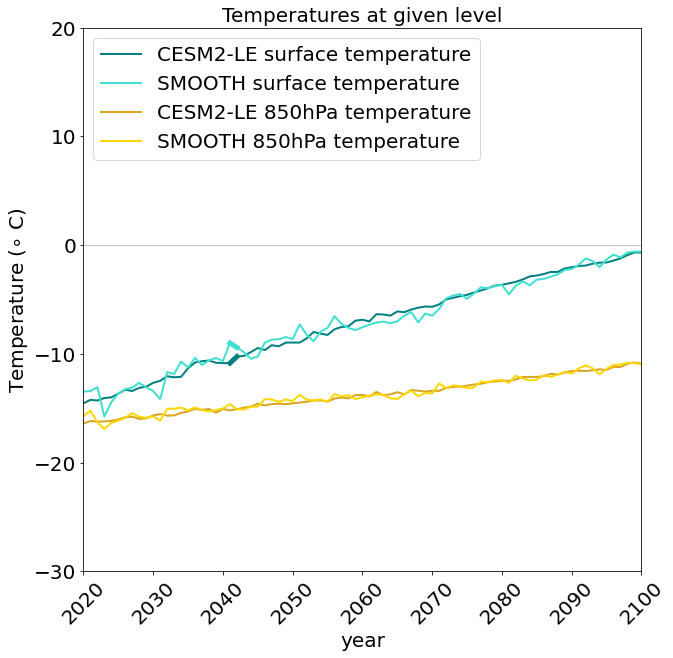

In [39]:
# like above, but add linear regression over the whole period
ind_le_st = 5
ind_le_ed = 85
ind_smooth_st = ind_le_st
ind_smooth_ed = ind_le_ed

# create figure
fig = plt.figure(figsize=(10,10))
# now loop through months to create subpanels
fout = 'fig_11_legend_'+out_tag

for ss in season_names[0:1]:
#for ss in season_names:
    #print(ss)
    if ss == 'OND':
        count = 0
    else: 
        count = count+1
    # get limits 
    ymin = ymin_all[count]
    ymax = ymax_all[count]
    ypos1 = ypos1_all[count]
    ypos2 = ypos2_all[count]

    # CESM2-LE: subset the data
    mean_le_1 = seas_ens_mean_le_1.isel(season=count)
    mean_le_sig_1 = seas_ens_mean_le_sig_1.isel(season=count)
    mean_le_2 = seas_ens_mean_le_2.isel(season=count)
    mean_le_sig_2 = seas_ens_mean_le_sig_2.isel(season=count)
    # rufmod: subset the data
    mean_smooth_1 = seas_ens_mean_smooth_1.isel(season=count)
    mean_smooth_sig_1 = seas_ens_mean_smooth_sig_1.isel(season=count)
    mean_smooth_2 = seas_ens_mean_smooth_2.isel(season=count)
    mean_smooth_sig_2 = seas_ens_mean_smooth_sig_2.isel(season=count)
        
    # Make subplot - note it's nrow x ncol x index (starting upper left)
    ax = fig.add_subplot(1,1,count+1)
    # plot ensemble means
    ax.plot(xarr_le,mean_le_1,label="CESM2-LE surface temperature",color='teal',linestyle='-',linewidth=2)
    ax.plot(xarr_smooth,mean_smooth_1,label="SMOOTH surface temperature",color='turquoise',linestyle='-',linewidth=2)
    ax.plot(xarr_le,mean_le_2,label="CESM2-LE 850hPa temperature",color='goldenrod',linestyle='-',linewidth=2)
    ax.plot(xarr_smooth,mean_smooth_2,label="SMOOTH 850hPa temperature",color='gold',linestyle='-',linewidth=2)
    # plot when ensemble means are significant
    ax.plot(xarr_le,mean_le_sig_1,color='teal',linestyle='-',linewidth=5)
    ax.plot(xarr_smooth,mean_smooth_sig_1,color='turquoise',linestyle='-',linewidth=5)    
    ax.plot(xarr_le,mean_le_sig_2,color='goldenrod',linestyle='-',linewidth=5)
    ax.plot(xarr_smooth,mean_smooth_sig_2,color='gold',linestyle='-',linewidth=5)    
    
    plt.title(label+'s at given level',fontsize=20)
    plt.xlabel('year',fontsize=20)
    plt.xticks(fontsize=20, rotation=45)
    plt.xlim([2020,2100])
    plt.ylabel(label+' '+units,fontsize=20)
    plt.yticks(fontsize=20)
    #plt.ylim([ymin,ymax])
    plt.ylim(-30,20)
    plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
    #plt.text(2021, ypos1, tx_le, fontsize=20, color='indigo')
    #plt.text(2021, ypos2, tx_smooth, fontsize=20, color='mediumpurple')
    plt.legend(loc=legpos,fontsize=20);
    
# Finalize figure and save
#fig.suptitle('Average '+label+' over Arctic Ocean',fontsize=15, y=0.95)  
fig.subplots_adjust(hspace=0.25)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
